# Tutorial 4
In this tutorial, we are going to directly train the weights and delays of a simple SNN with a single hidden layer using EventProp on the Yin-Yang dataset.

## Install
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    !gdown 1QF6eMWoqmOehbzXNSUbrImyBo0dTbv6J
    !pip install pygenn-5.2.0-cp311-cp311-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

    !rm -rf /content/ml_genn-ml_genn_2_3_1
    !wget https://github.com/genn-team/ml_genn/archive/refs/tags/ml_genn_2_3_1.zip
    !unzip -q ml_genn_2_3_1.zip
    !pip install ./ml_genn-ml_genn_2_3_1/ml_genn

Downloading...
From: https://drive.google.com/uc?id=1QF6eMWoqmOehbzXNSUbrImyBo0dTbv6J
To: /content/pygenn-5.2.0-cp311-cp311-linux_x86_64.whl
100% 8.60M/8.60M [00:00<00:00, 95.4MB/s]
Processing ./pygenn-5.2.0-cp311-cp311-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda
--2025-04-25 15:16:42--  https://github.com/genn-team/ml_genn/archive/refs/tags/ml_genn_2_3_1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/genn-team/ml_genn/zip/refs/tags/ml_genn_2_3_1 [following]
--2025-04-25 15:16:42--  https://codeload.github.com/genn-team/ml_genn/zip/refs/tags/ml_genn_2_3_1
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.20

## Build model
Import standard modules and required mlGeNN classes

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ml_genn import InputLayer, Layer, SequentialNetwork
from ml_genn.callbacks import Checkpoint, OptimiserParamSchedule
from ml_genn.compilers import EventPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.optimisers import Adam
from ml_genn.serialisers import Numpy
from ml_genn.synapses import Exponential

from ml_genn.utils.data import generate_yin_yang_dataset

from ml_genn.compilers.event_prop_compiler import default_params


##Parameters

Define some model parameters


In [3]:
NUM_INPUT = 5
NUM_HIDDEN = 30
NUM_OUTPUT = 3
BATCH_SIZE = 32
DT = 0.01
NUM_TRAIN = BATCH_SIZE * 10 * NUM_OUTPUT
NUM_TEST = BATCH_SIZE  * 2 * NUM_OUTPUT
EXAMPLE_TIME = 30.0

## Yin-yang dataset
We use the built in helper function to generate yin-yang data and visualise it:

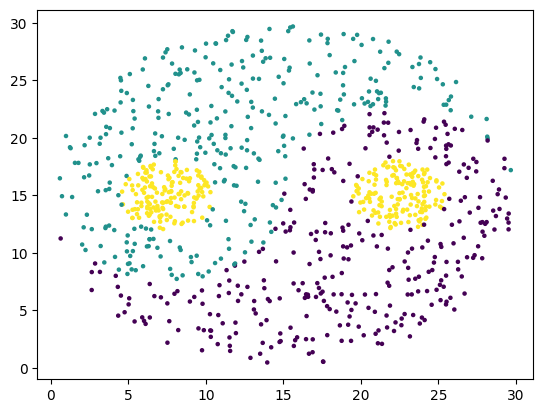

In [13]:
spikes_train, labels_train = generate_yin_yang_dataset(NUM_TRAIN, EXAMPLE_TIME - (4 * DT), 2 * DT)

x, y = zip(*(s.spike_times[1:3] for s in spikes_train))
fig, axis = plt.subplots()
axis.scatter(x, y, c=labels_train, s=5)

## Network definition
Because our network is entirely feedforward, we can define it as a ``SequentialNetwork`` where each layer is automatically connected to the previous layer. As the yin-yang dataset is already spiking, we will use a ``SpikeInput`` to inject these directly into the network. For our hidden layer we are going to use standard Leaky integrate-and-fire neurons. Finally, we are going to use a spiking output layer and read classifications out of this by determining which output neuron spikes first.



In [5]:
# Create sequential model
serialiser = Numpy("yin_yang_checkpoints")
network = SequentialNetwork(default_params)
with network:
    # Populations
    input = InputLayer(SpikeInput(max_spikes=BATCH_SIZE * NUM_INPUT),
                                  NUM_INPUT)
    hidden = Layer(Dense(Normal(mean=1.9, sd=0.78)),
                   LeakyIntegrateFire(v_thresh=1.0, tau_mem=20.0,
                                      tau_refrac=None),
                   NUM_HIDDEN, Exponential(5.0),
                   max_delay_steps=1000)
    output = Layer(Dense(Normal(mean=0.93, sd=0.1)),
                   LeakyIntegrateFire(tau_mem=20.0, readout="first_spike_time"),
                   NUM_OUTPUT, Exponential(5.0))

## Compilation
In mlGeNN, in order to turn an abstract network description into something that can actually be used for training or inference you use a *compiler* class. Here, we use the ``EventPropCompiler`` to train with EventProp and specify batch size and how many timesteps to evaluate each example for as well as choosing optimisers for weight and delay, the loss function and which connections to learn the delays of. Because this is a classification task, we want to use cross-entropy loss and, because our labels are specified in this way (rather than e.g. one-hot encoded), we use the sparse catgorical variant.

In [6]:
compiler = EventPropCompiler(example_timesteps=int(np.ceil(EXAMPLE_TIME / DT)),
                             losses="sparse_categorical_crossentropy",
                             optimiser=Adam(0.001), delay_optimiser=Adam(0.1), batch_size=BATCH_SIZE,
                             softmax_temperature=0.5, ttfs_alpha=0.1, dt=DT, delay_learn_conns=[hidden])
compiled_net = compiler.compile(network)

## Training
Now we will train the model for 100 epochs using our compiled network. We add additional callbacks to checkpoint weights and to decay all learning rates each epoch.



In [7]:
with compiled_net:
    callbacks = ["batch_progress_bar", Checkpoint(serialiser),
                 OptimiserParamSchedule("alpha", lambda epoch, alpha: alpha * 0.998)]
    compiled_net.train({input: spikes_train},
                       {output: labels_train},
                       num_epochs=100, shuffle=True,
                       callbacks=callbacks)

  0%|          | 0/30 [00:00<?, ?it/s]

## Evaluate
Load weights checkpointed from last epoch:

In [8]:
network.load((99,), serialiser)

Create an ``InferenceCompiler`` and compile the network for inference:

In [9]:
compiler = InferenceCompiler(evaluate_timesteps=int(np.ceil(EXAMPLE_TIME / DT)),
                             reset_in_syn_between_batches=True,
                             batch_size=BATCH_SIZE, dt=DT)
compiled_net = compiler.compile(network)

Generate a new dataset of yin-yang data and evaluate the model:

In [10]:
spikes_test, labels_test = generate_yin_yang_dataset(NUM_TEST, EXAMPLE_TIME - (4 * DT), 2 * DT)
with compiled_net:
    compiled_net.evaluate({input: spikes_test},
                          {output: labels_test})

  0%|          | 0/6 [00:00<?, ?it/s]